In [1]:
# NOTEBOOK FOR UNDERSAMPLING STRATEGIES
# remove all the consecutive duplicate clicks in a sample
# remove all the duplicate rows of clicks in the entire df  
#todo fix timedelta. right now the transformation for the time delta is ignored.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
text_num_mapping_start = 1
model_test_run = False #This reduces the data generated by selecting significantly lesser number of sessions to test the model
remove_consecutive_identical_clicks = False
#Todo implement identical consecutive clicks - only do that if the timedelta between clicks is quite less- otherwise it doesnt make sense.
sequence_augmentation = True
carsi_labels_only = True
regenerate_context_data = False
whole_session_context = False
data_autoencoder = False
pad_to_window_size = True
window = 100 #seconds
undersample_data = True

base_path = '../datasets/sequential/'
combined_context_path = '../data/05_Interaction_Sequences/context.csv'
augmentation_folder = 'aug/' if sequence_augmentation else 'non_aug/'
if model_test_run:
    augmentation_folder = 'test/aug/' if sequence_augmentation else 'test/non_aug/'
sequence_context_path = f'{base_path}{augmentation_folder}parameters/sequence_context.csv'
parameter_path = f'{base_path}{augmentation_folder}parameters'
sequence_path = f'{base_path}{augmentation_folder}seq'
train_session_path = f'{base_path}{augmentation_folder}parameters/train_sessions.pkl'
test_session_path = f'{base_path}{augmentation_folder}parameters/test_sessions.pkl'
train_dynamic_context_path = f'{base_path}{augmentation_folder}dynamic_context/train.csv'
test_dynamic_context_path = f'{base_path}{augmentation_folder}dynamic_context/test.csv'
train_static_context_path = f'{base_path}{augmentation_folder}static_context/train.csv'
test_static_context_path = f'{base_path}{augmentation_folder}static_context/test.csv'

dc_train_unnor_path = '../datasets/sequential/aug/dynamic_context/unnormal/train.csv'
dc_test_unnor_path = '../datasets/sequential/aug/dynamic_context/unnormal/test.csv'

In [4]:
# dc_train = pd.read_csv(train_dynamic_context_path)
# dc_test = pd.read_csv(test_dynamic_context_path)

dc_train = pd.read_csv(dc_train_unnor_path)
dc_test = pd.read_csv(dc_test_unnor_path)

sc_train = pd.read_csv(train_static_context_path)
sc_test = pd.read_csv(test_static_context_path)

seq_train = pd.read_csv(sequence_path+'/train.tsv', sep='\t')
seq_test = pd.read_csv(sequence_path+'/test.tsv', sep='\t')

In [5]:
dc_selected = ['avg_irradiation', 'steering_speed', 'temperature_out',
       'light_sensor_rear', 'light_sensor_front', 'temperature_in',
       'KBI_speed', 'soc', 'latitude', 'longitude', 'street_category',
       'altitude', 'time_second', 'distance_driven', 'window_id']
dc_train.columns

Index(['avg_irradiation', 'steering_speed', 'temperature_out',
       'light_sensor_rear', 'light_sensor_front', 'temperature_in',
       'KBI_speed', 'soc', 'latitude', 'longitude', 'street_category',
       'altitude', 'time_second', 'distance_driven', 'window_id', 'session',
       'datetime'],
      dtype='object')

In [7]:
#Todo to fix the timedelta after deleting the duplicates

# def split_consecutive(numbers):
#     if not numbers:
#         return []

#     # Initialize the list of lists to store consecutive sequences
#     result = [[numbers[0]]]

#     # Iterate through the numbers
#     for num in numbers[1:]:
#         # If the current number is consecutive to the last number in the last sublist
#         if num == result[-1][-1] + 1:
#             result[-1].append(num)  # Add it to the current sublist
#         else:
#             result.append([num])  # Otherwise, start a new sublist

#     return result


# def update_time_delta(row):
#     time_delta_list = row['interaction_time_delta_train_list']
    
#     removed_indices = row['removed_indices']
#     # print(time_delta_list)
#     # print(removed_indices)
#     updated_time_delta = []  # Initialize updated_time_delta variable
    
#     split = split_consecutive(removed_indices)

#     if len(removed_indices) != 0:
#         # for i in range(1, len(time_delta_list)):
#         #     if i not in removed_indices:
#         #         updated_time_delta.append(time_delta_list[i])
#         #     else:
#         #         new_time_delta = time_delta_list[i] + time_delta_list[i-1]
#         #         updated_time_delta.append(new_time_delta)
#         for count, i in enumerate(split):
#             print('count', count)
#             if count == 0:
#                 print('inside count =0', i)
#                 new_time_delta = time_delta_list[i[0]-1]
#             else:
#                 print('i am here')
#                 print(i)
#                 print(new_time_delta)
#                 new_time_delta = updated_time_delta[-1]
#                 print(new_time_delta)
#             for j in i:
#                 print('inside for loop',j)
#                 new_time_delta = new_time_delta + time_delta_list[j]
#             updated_time_delta.append(new_time_delta)
#     else:
#         updated_time_delta = time_delta_list  # Assign original time_delta_list
    
#     return updated_time_delta  # Return the updated list

# seq_train_updated['updated_interaction_time_delta'] = seq_train_updated[['interaction_time_delta_train_list', 'removed_indices']].apply(update_time_delta, axis=1)

In [8]:
seq_train_updated['dup_check'] = seq_train_updated['item_id_seq_train'] + '_' + seq_train_updated['item_id_target'].astype(str)
duplicate_rows = seq_train_updated[seq_train_updated.duplicated(subset=['dup_check'], keep=False)]
duplicate_rows['dup_item_id_seq_train_list'] = duplicate_rows['item_id_seq_train'].str.split().apply(lambda x: [int(i) for i in x])
duplicate_rows['item_id_sum'] = duplicate_rows['dup_item_id_seq_train_list'].apply(lambda x: sum(x))
duplicate_rows = duplicate_rows.sort_values(by=['item_id_sum', 'item_id_target'])
duplicate_rows['dup_id'] = duplicate_rows.groupby('dup_check').ngroup()
# duplicate_rows['dup_id'] = duplicate_rows['dup_id'] - duplicate_rows['dup_id'].min()
duplicate_rows = duplicate_rows.sort_values(by='dup_id')
duplicate_rows.to_csv('duplicate rows.csv')
duplicate_rows

/var/folders/n8/1ntcg5gj7nvf5wh_s2w95yh80000gn/T/ipykernel_7602/3025388035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq_train_updated['dup_check'] = seq_train_updated['item_id_seq_train'] + '_' + seq_train_updated['item_id_target'].astype(str)
/var/folders/n8/1ntcg5gj7nvf5wh_s2w95yh80000gn/T/ipykernel_7602/3025388035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_rows['dup_item_id_seq_train_list'] = duplicate_rows['item_id_seq_train'].str.split().apply(lambda x: [int(i) for i in x]

,window_id,item_id_seq_train,item_id_target,wrong_time_delta_interaction,session,dup_check,dup_item_id_seq_train_list,item_id_sum,dup_id
1265,1265,1 15 2,7,0 0 0,1401.0,1 15 2_7,"[1, 15, 2]",18,0
1361,1361,1 15 2,7,0 0 0,1565.0,1 15 2_7,"[1, 15, 2]",18,0
1362,1362,1 15,2,0 0,1565.0,1 15_2,"[1, 15]",16,1
1266,1266,1 15,2,0 0,1401.0,1 15_2,"[1, 15]",16,1
1024,1024,1 15,7,0 0,1311.0,1 15_7,"[1, 15]",16,2
...,...,...,...,...,...,...,...,...,...
2957,2957,9,9,0,3953.0,9_9,[9],9,365
2963,2963,9,9,0,3959.0,9_9,[9],9,365
2956,2956,9,9,0,3953.0,9_9,[9],9,365
2955,2955,9,9,0,3953.0,9_9,[9],9,365


In [9]:
import matplotlib.pyplot as plt

def plot_dc(df):
    unique_window_ids = df['window_id'].unique()
    num_subplots = len(df.columns)
    num_unique_ids = len(unique_window_ids)

    fig, axes = plt.subplots(nrows=num_subplots, ncols=num_unique_ids, figsize=(12*num_unique_ids, 6*num_subplots))

    for i, column in enumerate(df.columns):
        for j, window_id in enumerate(unique_window_ids):
            data_subset = df[df['window_id'] == window_id]
            axes[i, j].plot(data_subset.index, data_subset[column])
            axes[i, j].set_title(f"{column} - Window ID {window_id}")
            axes[i, j].set_xlabel('Index', fontsize=12)  # Increase font size of x-label
            axes[i, j].set_ylabel('Values', fontsize=12)  # Increase font size of y-label
            axes[i, j].grid(True)
            axes[i, j].legend([column], loc='upper left')

    plt.tight_layout()
    plt.show()

# row = duplicate_rows[duplicate_rows['dup_id']==26]
# window_ids = row.window_id.tolist()
# print(sorted(window_ids))
# dc_train_curr = dc_train[dc_train['window_id'].isin(window_ids)]
# dc_train_curr = dc_train_curr[dc_selected]
# plot_dc(dc_train_curr)

dup_id_window_dict = {}

for index, row in duplicate_rows.iterrows():
    dup_id = row['dup_id']
    window_id = row['window_id']
    if dup_id not in dup_id_window_dict:
        dup_id_window_dict[dup_id] = []
    dup_id_window_dict[dup_id].append(window_id)

dup_id_window_dict
import random
random_dup_id_window_dict = {}
for dup_id, window_ids in dup_id_window_dict.items():
    random_window_id = random.choice(window_ids)
    random_dup_id_window_dict[dup_id] = random_window_id
print(random_dup_id_window_dict)

random_window_ids_list = list(random_dup_id_window_dict.values())
print(sorted(random_window_ids_list))

dropped_windows = sorted(duplicate_rows[~duplicate_rows['window_id'].isin(random_window_ids_list)]['window_id'].tolist())
print(dropped_windows)

{0: 1265, 1: 1362, 2: 1172, 3: 676, 4: 626, 5: 630, 6: 182, 7: 370, 8: 616, 9: 150, 10: 202, 11: 174, 12: 1210, 13: 2571, 14: 1827, 15: 925, 16: 1026, 17: 2143, 18: 2350, 19: 2448, 20: 2443, 21: 2203, 22: 2449, 23: 2288, 24: 1926, 25: 1928, 26: 1219, 27: 995, 28: 1288, 29: 998, 30: 810, 31: 1071, 32: 1811, 33: 831, 34: 2171, 35: 1795, 36: 2387, 37: 1591, 38: 2191, 39: 1592, 40: 2219, 41: 837, 42: 838, 43: 2257, 44: 2269, 45: 1778, 46: 1428, 47: 1174, 48: 1175, 49: 1886, 50: 1321, 51: 1322, 52: 1890, 53: 1891, 54: 1718, 55: 1326, 56: 1864, 57: 1869, 58: 1184, 59: 1871, 60: 1994, 61: 1874, 62: 1657, 63: 1499, 64: 2026, 65: 2455, 66: 4248, 67: 1797, 68: 2233, 69: 2334, 70: 2376, 71: 1020, 72: 1903, 73: 1907, 74: 1916, 75: 1031, 76: 2303, 77: 2465, 78: 1602, 79: 4413, 80: 1032, 81: 1603, 82: 4215, 83: 1692, 84: 891, 85: 1045, 86: 2355, 87: 1554, 88: 1042, 89: 1813, 90: 1605, 91: 667, 92: 1025, 93: 344, 94: 203, 95: 1211, 96: 58, 97: 378, 98: 553, 99: 648, 100: 461, 101: 381, 102: 496, 103:

In [10]:
dc_train = pd.read_csv(train_dynamic_context_path)
dc_test = pd.read_csv(test_dynamic_context_path)

dc_train = dc_train[~dc_train['window_id'].isin(dropped_windows)].reset_index(drop=True)
dc_test = dc_test[~dc_test['window_id'].isin(dropped_windows)].reset_index(drop=True)

sc_train = pd.read_csv(train_static_context_path)
sc_test = pd.read_csv(test_static_context_path)

sc_train = sc_train[~sc_train['window_id'].isin(dropped_windows)].reset_index(drop=True)
sc_test = sc_test[~sc_test['window_id'].isin(dropped_windows)].reset_index(drop=True)

seq_train_updated = seq_train_updated[~seq_train_updated['window_id'].isin(dropped_windows)].reset_index(drop=True)
seq_test_updated = seq_test_updated[~seq_test_updated['window_id'].isin(dropped_windows)].reset_index(drop=True)

In [11]:
print(len(dc_train.window_id.unique().tolist()),
       len(dc_test.window_id.unique().tolist()),
       len(sc_train.window_id.unique().tolist()),
       len(sc_test.window_id.unique().tolist()),
       len(seq_train_updated.window_id.unique().tolist()),
       len(seq_test_updated.window_id.unique().tolist())
      )

2245 441 2245 441 2245 441


In [12]:
augmentation_folder = 'undersampling/'
sequence_path = f'{base_path}{augmentation_folder}seq/'
dynamic_context_path = f'{base_path}{augmentation_folder}dynamic_context/'
static_context_path = f'{base_path}{augmentation_folder}static_context/'

if not os.path.exists(sequence_path):
    os.makedirs(sequence_path)

if not os.path.exists(train_dynamic_context_path):
    os.makedirs(train_dynamic_context_path)

if not os.path.exists(train_static_context_path):
    os.makedirs(train_static_context_path)

dc_train['window_id'] = dc_train.groupby('window_id').ngroup()
dc_test['window_id'] = dc_test.groupby('window_id').ngroup()
sc_train['window_id'] = sc_train.groupby('window_id').ngroup()
sc_test['window_id'] = sc_test.groupby('window_id').ngroup()
seq_test_updated['window_id'] = seq_test_updated.groupby('window_id').ngroup()
seq_train_updated['window_id'] = seq_train_updated.groupby('window_id').ngroup()

dynamic_context_to_normalize = [col for col in dc_train.columns if col not in ['window_id', 'session_ids', 'datetime', 'session_id', 'session']]
scaler_dynamic_context = MinMaxScaler()
scaler_dynamic_context.fit(dc_train[dynamic_context_to_normalize])
dc_train[dynamic_context_to_normalize] = scaler_dynamic_context.transform(dc_train[dynamic_context_to_normalize])
dc_test[dynamic_context_to_normalize] = scaler_dynamic_context.transform(dc_test[dynamic_context_to_normalize])

dc_train.to_csv(dynamic_context_path+'train.csv', index=False)
dc_test.to_csv(dynamic_context_path+'test.csv', index=False)

sc_train.to_csv(static_context_path+'train.csv', index=False)
sc_test.to_csv(static_context_path+'test.csv', index=False)

cols_to_keep = ['window_id', 'item_id_seq_train', 'item_id_target', 'wrong_time_delta_interaction', 'session']
seq_test_updated['session']   = seq_test_updated['session'].astype(int)
seq_train_updated['session']   = seq_train_updated['session'].astype(int)

seq_test_updated = seq_test_updated[cols_to_keep]
seq_train_updated = seq_train_updated[cols_to_keep]

seq_test_updated.to_csv(sequence_path+'test.tsv', sep='\t', index=False)
seq_train_updated.to_csv(sequence_path+'train.tsv', sep='\t', index=False)

In [13]:
seq_test_updated

,window_id,item_id_seq_train,item_id_target,wrong_time_delta_interaction,session
0,0,2 5,2,0 0,173
1,1,2 1 3 2,2,0 0 0 0,277
2,2,2 1 3,2,0 0 0,277
3,3,2 1,3,0 0,277
4,4,2,3,0,433
...,...,...,...,...,...
436,436,2,6,0,5341
437,437,2,2,0,5341
438,438,5,15,0,5346
439,439,7 11,7,0 0,5399


In [14]:
import torch 
parameter_path = f'{base_path}{augmentation_folder}parameters'
if not os.path.exists(parameter_path):
    os.makedirs(parameter_path)

df_exploded = pd.concat([seq_test_updated, seq_train_updated], axis=0)

def compute_class_weights(data):
    labels = torch.tensor(data['item_id_target'].values)
    class_count = torch.bincount(labels)
    total_samples = len(labels)
    epsilon = 1e-5
    class_weights = 1.0 / ((class_count.float()) / total_samples)
    small_value = 1e-20
    class_weights[torch.isinf(class_weights)] = small_value
    # class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)
    sum_weights = torch.sum(class_weights)
    class_weights = class_weights / sum_weights
    return class_weights

class_weights = compute_class_weights(df_exploded)
# class_weights = class_weights[1:]
with open(os.path.join(parameter_path, 'param.pkl'), 'wb') as f:
        pickle.dump(class_weights, f)

print(class_weights.size(), len(df_exploded.item_id_target.unique().tolist()))
print(class_weights)

torch.Size([29]) 26
tensor([1.2130e-24, 3.2259e-03, 6.0226e-04, 3.5415e-03, 1.3138e-03, 8.9266e-04,
        1.5515e-03, 6.8021e-04, 2.0364e-02, 1.7148e-02, 1.2130e-24, 1.2067e-02,
        3.6202e-02, 2.3273e-02, 4.0728e-02, 9.3627e-04, 3.6202e-02, 1.9166e-02,
        4.6546e-02, 1.5515e-02, 1.6291e-01, 1.2130e-24, 3.2582e-01, 1.1235e-02,
        1.9166e-02, 1.4810e-02, 1.8101e-02, 1.6291e-01, 5.0909e-03])


26


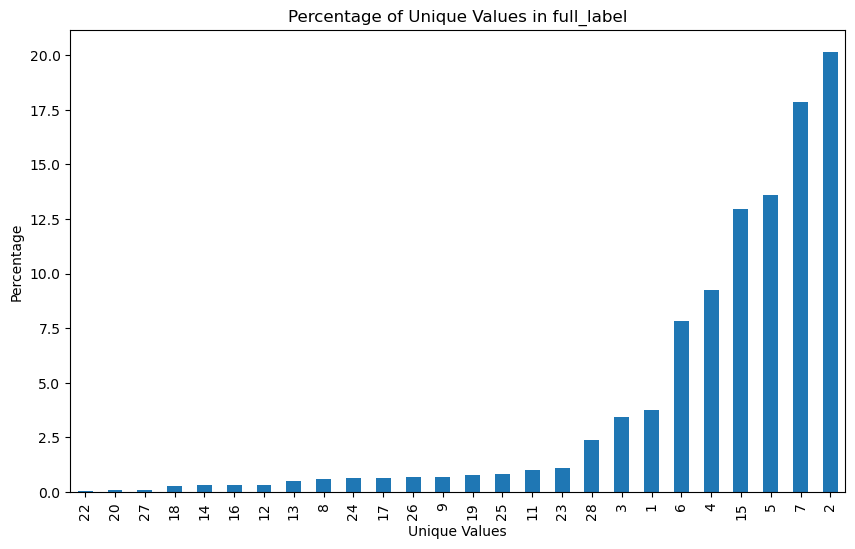

In [15]:
def plot_labels(df):
    print(len(df['item_id_target'].unique().tolist()))
    import matplotlib.pyplot as plt

    # Assuming your DataFrame is named full_df
    value_counts = df['item_id_target'].value_counts(normalize=True).sort_values() * 100

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar')
    plt.title('Percentage of Unique Values in full_label')
    plt.xlabel('Unique Values')
    plt.ylabel('Percentage')
    plt.show()

plot_labels(df_exploded)

26


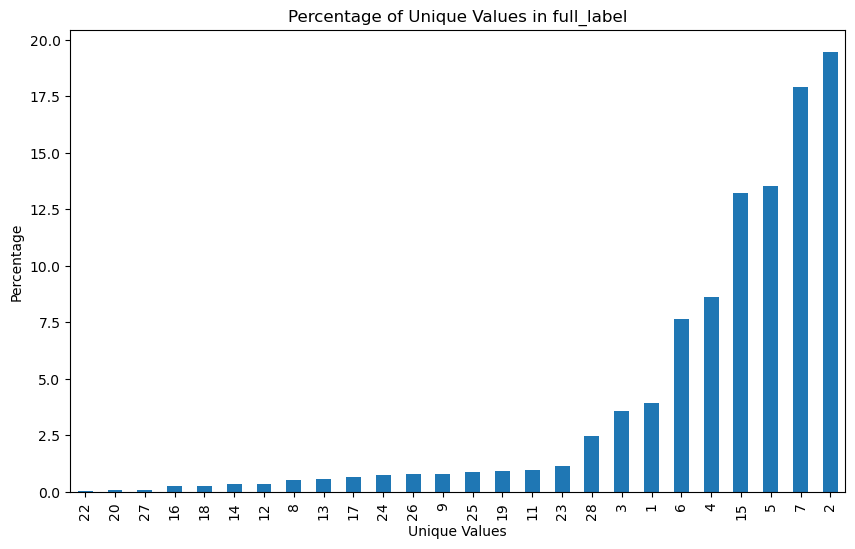

In [16]:
plot_labels(seq_train_updated)

19


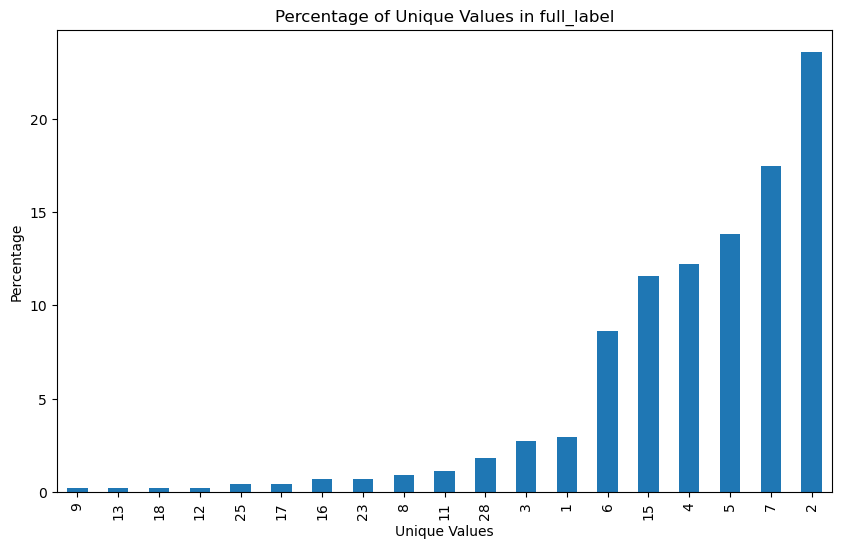

In [17]:
plot_labels(seq_test_updated)